In [1]:
import sys
sys.path.extend(["../../../../"])

In [1]:
from onsager.crystal import Crystal
from onsager.crystalStars import zeroclean
from onsager.OnsagerCalc import *
from onsager.crystal import DB_disp, DB_disp4, pureDBContainer, mixedDBContainer
from onsager.DB_structs import dumbbell, SdPair, jump, connector

In [27]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# make a BCC lattice
# We'll modify the jumpnetwork to keep only the 60 degree reorientational jumps.
a0 = 1.0
latt = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]) * a0
Fe = crystal.Crystal(latt, [[np.array([0., 0., 0.]), np.array([0.5, 0.5, 0.5])]], ["Fe"])
# Now give it the orientations - for BCC it's [110]
o = np.array([1.,1.,0.])/np.linalg.norm(np.array([1.,1.,0.]))*a0/4
famp0 = [o.copy()]
family = [famp0]
pdbcontainer_fe = pureDBContainer(Fe, 0, family)
mdbcontainer_fe = mixedDBContainer(Fe, 0, family)
jcut = np.sqrt(3)*1.01*a0/2.
jset0, jset2 = pdbcontainer_fe.jumpnetwork(jcut, 0.01, 0.01), mdbcontainer_fe.jumpnetwork(jcut, 0.01, 0.01)
print(Fe)

#Lattice:
  a1 = [0.5 0.5 0.5]
  a2 = [-0.5  0.5 -0.5]
  a3 = [-0.5 -0.5  0.5]
#Basis:
  (Fe) 0.0 = [0. 0. 0.]


In [3]:
# Modify jnet0
jnet0 = jset0[0]
jnet0_indexed = jset0[1]
# Let's try to sort the jumps according to closest distance
# except rotational jumps, we don't want them.
z = np.zeros(3)
indices = []

for jt, jlist in enumerate(jnet0):
    if np.allclose(jnet0_indexed[jt][0][1], z):
        continue
    indices.append(jt)
    
def sortkey(entry):
    jmp = jnet0[entry][0]
    or1 = pdbcontainer_fe.iorlist[jmp.state1.iorind][1]
    or2 = pdbcontainer_fe.iorlist[jmp.state2.iorind][1]
    dx = DB_disp(pdbcontainer_fe, jmp.state1, jmp.state2)
    dx1 = np.linalg.norm(jmp.c1*or1/2.)
    dx2 = np.linalg.norm(dx + jmp.c2*or2/2. - jmp.c1*or1/2.)
    dx3 = np.linalg.norm(-jmp.c2*or2/2.)
    return dx1+dx2+dx3
ind_sort = sorted(indices, key=sortkey)

In [4]:
# Let's check if we got the correct jump
print(jnet0[ind_sort[0]][0])

Jump object:
Initial state:
	dumbbell : (i, or) index = 4, lattice vector = [0 0 0]
Final state:
	dumbbell : (i, or) index = 2, lattice vector = [1 0 0]
Jumping from c1 = -1 to c2 = -1



In [5]:
pdbcontainer_fe.iorlist

[(0, array([-0.1767767,  0.1767767,  0.       ])),
 (0, array([-0.1767767,  0.       ,  0.1767767])),
 (0, array([0.1767767, 0.       , 0.1767767])),
 (0, array([ 0.       ,  0.1767767, -0.1767767])),
 (0, array([-0.1767767, -0.1767767,  0.       ])),
 (0, array([0.       , 0.1767767, 0.1767767]))]

In [6]:
# take only the lowest displacement jump
# that is the jump we want.
jset0new = ([jnet0[ind_sort[0]]], [jnet0_indexed[ind_sort[0]]])

In [7]:
# Now, we modify the mixed dumbbell jumpnetwork to also give the lowest displacement jump
# Modify jnet0
jnet2 = jset2[0]
jnet2_indexed = jset2[1]
# Let's try to sort the jumps according to closest distance
# we don't want the rotational jumps as before.
z = np.zeros(3)
indices2 = []
for jt, jlist in enumerate(jnet2):
    if np.allclose(jnet2_indexed[jt][0][1], z):
        continue
    indices2.append(jt)    
print(indices2)

def sortkey2(entry):
    jmp = jnet2[entry][0]
    or1 = mdbcontainer_fe.iorlist[jmp.state1.db.iorind][1]
    or2 = mdbcontainer_fe.iorlist[jmp.state2.db.iorind][1]
    dx = DB_disp(mdbcontainer_fe, jmp.state1, jmp.state2)
    # c1 and c2 are always +1 for mixed dumbbell jumps.
    dx1 = np.linalg.norm(jmp.c1*or1/2.)
    dx2 = np.linalg.norm(dx + jmp.c2*or2/2. - jmp.c1*or1/2.)
    dx3 = np.linalg.norm(-jmp.c2*or2/2.)
    return dx1+dx2+dx3
ind_sort2 = sorted(indices2, key=sortkey2)
print(ind_sort2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[15, 16, 14, 8, 7, 0, 9, 1, 12, 10, 13, 11, 3, 4, 2, 5, 6]


In [8]:
# check if we have the correct type of jump
print(jnet2[ind_sort2[0]][0])

Jump object:
Initial state:
	Solute loctation:basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 4, lattice vector = [0 0 0]
Final state:
	Solute loctation :basis index = 0, lattice vector = [0 1 0]
	dumbbell : (i, or) index = 11, lattice vector = [0 1 0]
Jumping from c1 = 1 to c2 = 1


In [9]:
for tup in mdbcontainer_fe.iorlist:
    print(tup)

(0, array([-0.1767767,  0.1767767,  0.       ]))
(0, array([-0.1767767,  0.       ,  0.1767767]))
(0, array([0.1767767, 0.       , 0.1767767]))
(0, array([ 0.       ,  0.1767767, -0.1767767]))
(0, array([-0.1767767,  0.       , -0.1767767]))
(0, array([ 0.       , -0.1767767,  0.1767767]))
(0, array([-0.1767767, -0.1767767,  0.       ]))
(0, array([0.       , 0.1767767, 0.1767767]))
(0, array([ 0.       , -0.1767767, -0.1767767]))
(0, array([ 0.1767767,  0.       , -0.1767767]))
(0, array([0.1767767, 0.1767767, 0.       ]))
(0, array([ 0.1767767, -0.1767767,  0.       ]))


In [10]:
# take only the lowest displacement jump
# that is the jump we want.
jset2new = ([jnet2[ind_sort2[0]]], [jnet2_indexed[ind_sort2[0]]])

In [11]:
# Now, we construct the Onsager calculator with these non-local jump sets.
start = time.time()
onsagercalculator = dumbbellMediated(pdbcontainer_fe, mdbcontainer_fe, jset0new, jset2new, jcut,
                                     0.01, 0.01, 0.01, NGFmax=4, Nthermo=1)
print("onsager calculator initiation time = {}".format(time.time() - start))

initializing thermo
initializing kin
generating thermodynamic shell
built shell 1: time - 0.028833866119384766
grouped states by symmetry: 0.09620833396911621
built mixed dumbbell stars: 0.0005962848663330078
built jtags2: 0.0003590583801269531
built mixed indexed star: 0.01267695426940918
building star2symlist : 7.748603820800781e-05
building bare, mixed index dicts : 0.00024271011352539062
thermodynamic shell generated: 0.21755027770996094
Total number of states in Thermodynamic Shell - 54, 12
generating kinetic shell
built shell 1: time - 0.02924633026123047
built shell 2: time - 0.9159579277038574
grouped states by symmetry: 0.9748637676239014
built mixed dumbbell stars: 0.0004055500030517578
built jtags2: 0.00013971328735351562
built mixed indexed star: 0.006021738052368164
building star2symlist : 7.2479248046875e-05
building bare, mixed index dicts : 0.00015497207641601562
Kinetic shell generated: 2.8836848735809326
Total number of states in Kinetic Shell - 210, 12
generating kin

In [12]:
onsagercalculator.om1types

[0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
# First, we must also modify the omega3 and omega4 jump lists
# NOTE - I am modifying these lists in place right now.
# But I must come up with a way to do this separately
len(onsagercalculator.jnet43)

26

In [14]:
# Next, we must also modify the omega3 and omega4 jump lists
jnet43 = onsagercalculator.jnet43
jnet43_indexed = onsagercalculator.jnet43_indexed
# Let's try to sort the jumps according to closest distance
# we don't want the rotational jumps as before.

z = np.zeros(3)
indices43 = []
for jt, jlist in enumerate(jnet43):
    if np.allclose(jnet43_indexed[jt][0][1], z):
        continue
    indices43.append(jt)    
# print(indices43)

def sortkey43(entry):
    jmp = jnet43[entry][0] # This is an omega4 jump
    if not jmp.c2 == -1:
        print(c2)
    or1 = pdbcontainer_fe.iorlist[jmp.state1.db.iorind][1]
    or2 = mdbcontainer_fe.iorlist[jmp.state2.db.iorind][1]
    dx = DB_disp4(pdbcontainer_fe, mdbcontainer_fe, jmp.state1, jmp.state2)
    # remember that c2 is -1 for an omega4 jump
    dx1 = np.linalg.norm(jmp.c1*or1/2.)
    dx2 = np.linalg.norm(dx - or2/2. - jmp.c1*or1/2.)
    dx3 = np.linalg.norm(jmp.c2*or2/2.)
    return dx1+dx2+dx3

ind_sort43 = sorted(indices43, key=sortkey43)
print(ind_sort43)

[16, 24, 8, 14, 10, 12, 9, 18, 0, 22, 25, 2, 6, 17, 20, 3, 7, 1, 5, 19, 11, 13, 4, 15, 21, 23]


In [15]:
# check if we have the correct jump
print(jnet43[ind_sort43[0]][0])

Jump object:
Initial state:
	Solute loctation:basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 0, lattice vector = [ 0 -1  0]
Final state:
	Solute loctation :basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 4, lattice vector = [0 0 0]
Jumping from c1 = 1 to c2 = -1


In [16]:
pdbcontainer_fe.iorlist

[(0, array([-0.1767767,  0.1767767,  0.       ])),
 (0, array([-0.1767767,  0.       ,  0.1767767])),
 (0, array([0.1767767, 0.       , 0.1767767])),
 (0, array([ 0.       ,  0.1767767, -0.1767767])),
 (0, array([-0.1767767, -0.1767767,  0.       ])),
 (0, array([0.       , 0.1767767, 0.1767767]))]

In [17]:
mdbcontainer_fe.iorlist

[(0, array([-0.1767767,  0.1767767,  0.       ])),
 (0, array([-0.1767767,  0.       ,  0.1767767])),
 (0, array([0.1767767, 0.       , 0.1767767])),
 (0, array([ 0.       ,  0.1767767, -0.1767767])),
 (0, array([-0.1767767,  0.       , -0.1767767])),
 (0, array([ 0.       , -0.1767767,  0.1767767])),
 (0, array([-0.1767767, -0.1767767,  0.       ])),
 (0, array([0.       , 0.1767767, 0.1767767])),
 (0, array([ 0.       , -0.1767767, -0.1767767])),
 (0, array([ 0.1767767,  0.       , -0.1767767])),
 (0, array([0.1767767, 0.1767767, 0.       ])),
 (0, array([ 0.1767767, -0.1767767,  0.       ]))]

In [18]:
onsagercalculator.regenerate43([ind_sort43[0]])

In [51]:
kT = 1

predb0, enedb0 = np.ones(1), np.zeros(1)

preS, eneS = np.ones(1), np.zeros(1)

# These are the interaction or the excess energies and pre-factors for solutes and dumbbells.
# The energies will all be zero.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)

predb2, enedb2 = predb0.copy(), enedb0.copy()

preT0, eneT0 = np.ones(len(onsagercalculator.vkinetic.starset.jnet0)), enedb0.copy()
preT2, eneT2 = preT0.copy(), eneT0.copy()
preT1, eneT1 = np.ones(len(onsagercalculator.jnet1)), np.array([eneT0[onsagercalculator.om1types[jt]] for jt in
                                                                range(len(onsagercalculator.jnet1))])

preT43, eneT43 = np.ones(len(onsagercalculator.jnet43)), eneT0.copy()

In [52]:
# 1b. Now get the beta*free energy values.
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

In [53]:
# get the probabilities and other data from L_ij
L0bb,(L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

In [54]:
L_aa = L_uc_aa + L_c_aa

In [55]:
L_ab = L_uc_ab + L_c_ab

In [56]:
L_aa[0][0]/L_ab[0][0]

0.41264340979628666

In [57]:
onsagercalculator.vkinetic.Nvstars, len(onsagercalculator.jnet2)

(17, 1)

In [58]:
onsagercalculator.omegas[4][1]

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [59]:
onsagercalculator.omegas[3][1]

array([[1.]])

In [60]:
# Now, we vary omega43 as a multiple of omega0 and see how our tracer drag ratio changes
Npoints = 31
inc2vs0 = np.linspace(-10, 10, Npoints)
inc43vs0 = np.linspace(-10, 10, Npoints)

# put the following into a loop - first determine how to vary omega43 rates
tcf = np.zeros(len(inc2vs0)*len(inc43vs0))
tdrag = np.zeros(len(inc2vs0)*len(inc43vs0))

omega4 = np.zeros(len(inc2vs0)*len(inc43vs0))
omega3 = np.zeros(len(inc2vs0)*len(inc43vs0))
omega2 = np.zeros(len(inc2vs0)*len(inc43vs0))

for i in tqdm(range(len(inc2vs0)), position=0, leave=True):
    
    # First, we vary omega2 rate with respect to omega0 rate
    eneT2 = np.array([eneT0[0] + inc2vs0[i]])
    
    for j in range(len(inc43vs0)):
        
        # Then, we'll vary the omega43 rate with respect to omega0 rate
        eneT43 = np.array([eneT0[0] + inc43vs0[j]])

        bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
            onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                                   preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
        
        L0bb,(L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
        onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

        L_aa = L_uc_aa + L_c_aa
        L_ab = L_uc_ab + L_c_ab

        tcf[i*len(inc2vs0) + j] = L_aa[0][0]/L_ab[0][0]
        tdrag[i*len(inc2vs0) + j] = L_ab[0][0]/L_aa[0][0]

        omega4[i*len(inc2vs0) + j] = onsagercalculator.omegas[4][0][0]/onsagercalculator.omegas[0][0][0]
        omega3[i*len(inc2vs0) + j] = onsagercalculator.omegas[3][0][0]/onsagercalculator.omegas[0][0][0]
        omega2[i*len(inc2vs0) + j] = onsagercalculator.omegas[2][0][0]/onsagercalculator.omegas[0][0][0]

100%|██████████| 31/31 [18:21<00:00, 35.54s/it]


In [61]:
om3 = omega3.reshape(len(inc2vs0),len(inc43vs0))
om2 = omega2.reshape(len(inc2vs0),len(inc43vs0))
z = tdrag.reshape(len(inc2vs0),len(inc43vs0))

In [62]:
# 1. Set the rates and thermodynamic data
kT = 1

predb0, enedb0 = np.ones(1), np.zeros(1)

preS, eneS = np.ones(1), np.zeros(1)

# These are the interaction or the excess energies and pre-factors for solutes and dumbbells.
# The energies will all be zero.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)

predb2, enedb2 = predb0.copy(), enedb0.copy()

preT0, eneT0 = np.ones(len(onsagercalculator.vkinetic.starset.jnet0)), enedb0.copy()
preT2, eneT2 = preT0.copy(), eneT0.copy()
preT1, eneT1 = np.ones(len(onsagercalculator.jnet1)), np.array([eneT0[onsagercalculator.om1types[jt]] for jt in
                                                                range(len(onsagercalculator.jnet1))])

preT43, eneT43 = np.ones(len(onsagercalculator.jnet43)), eneT0.copy()

fix_en = enedb0[0]
fix_ts_en = eneT0[0]
Npoints = 51
change2 = np.linspace(0, 5, Npoints)
tcf43 = np.zeros(len(change2))
tdrag43 = np.zeros(len(change2))

omega4 = np.zeros(len(change2))
omega3 = np.zeros(len(change2))
omega0 = np.zeros(len(change2))
omega2 = np.zeros(len(change2))


omega4esc = np.zeros(len(change2))
omega3esc = np.zeros(len(change2))
omega0esc = np.zeros(len(change2))
omega2esc = np.zeros(len(change2))


for i in tqdm(range(len(change2)), position=0, leave=True):
    
    # Now, make omega3 easier than omega4 by raising the mixed dumbbell energy, the omega2 TS energy
    # and the omega43 TS energy by the same amount.
    
    enedb2 = np.array([fix_en + change2[i]]) 
    eneT2 = np.array([fix_ts_en + change2[i]])
    eneT43 = np.array([fix_ts_en + change2[i]])
    
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
    
    
    L0bb,(L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
        onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_ab = L_uc_ab + L_c_ab
    
    tcf43[i] = L_aa[0][0]/L_ab[0][0]
    tdrag43[i] = L_ab[0][0]/L_aa[0][0]
    
    omegas = onsagercalculator.omegas
    
    omega4[i] = omegas[4][0][0]
    omega3[i] = omegas[3][0][0]
    omega2[i] = omegas[2][0][0]
    omega0[i] = omegas[0][0][0]
    
    omega4esc[i] = omegas[4][1][2][0]
    omega3esc[i] = omegas[3][1][0][0]
    omega0esc[i] = omegas[0][1][0][0]
    omega2esc[i] = omegas[2][1][0][0]

100%|██████████| 51/51 [01:02<00:00,  1.23s/it]


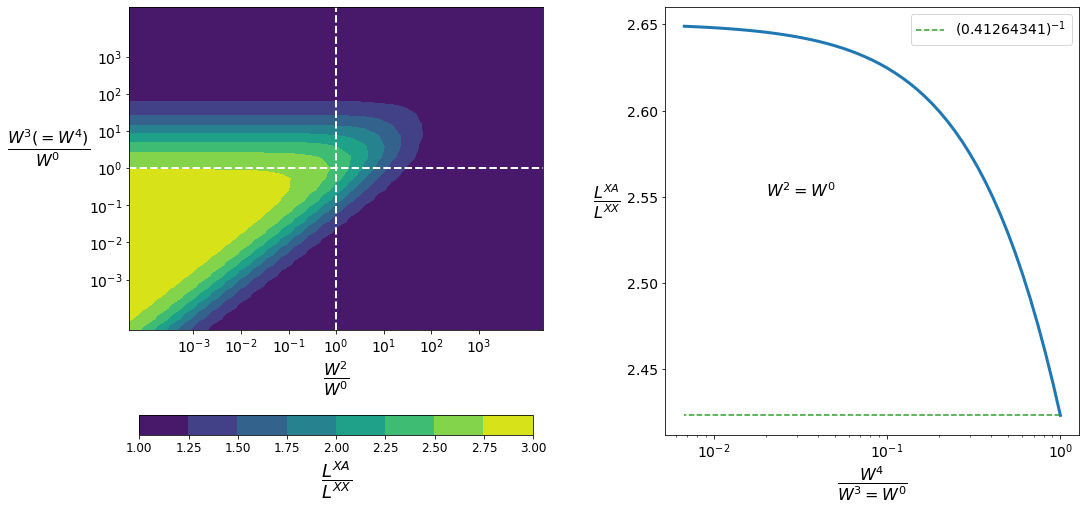

In [63]:
fig,[ax1, ax2] = plt.subplots(1,2, figsize=(16,8))
cp = ax1.contourf(om2, om3, z)

# # trying to plot lines now
ax1.plot([np.min(om3), np.max(om3)],[1, 1], color="w",lw=2, ls="--")
ax1.plot([1, 1],[np.min(om3), np.max(om3)], color="w",lw=2, ls="--")

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlabel(r'$\dfrac{W^2}{W^0}$', fontsize=16)
ax1.set_ylabel(r'$\dfrac{W^3(=W^4)}{W^0}$', rotation=0, labelpad=40, fontsize=16)

ax1.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ax1.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])

ax1.tick_params(axis='both', which='major', labelsize=14)

cbar = fig.colorbar(cp, ax=ax1, orientation ="horizontal", fraction=0.046, pad=0.2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\dfrac{L^{XA}}{L^{XX}}$', rotation=0, fontsize=18)

ax2.semilogx(omega4esc/omega3esc, tdrag43, color="tab:blue", lw=3)
ax2.semilogx(omega4esc/omega3esc, np.ones_like(tdrag43)/0.41264341, ls="--", label=r'$(0.41264341)^{-1}$',
             color="tab:green")
ax2.legend(fontsize=14)
# ax2.set_xlim(0.00673795, 1)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax2.text(2e-2, 2.55, r'$W^2=W^0$', fontsize=16)
ax2.set_xlabel(r'$\dfrac{W^4}{W^3=W^0}$', fontsize=16)
ax2.set_ylabel(r'$\dfrac{L^{XA}}{L^{XX}}$', rotation=0, labelpad=20, fontsize=16)

fig.tight_layout(pad=4.0)
# plt.savefig("BCC_Drag_contour.png")

In [64]:
om2[15,15], om3[15,15], z[15,15]

(1.0, 1.0, 2.4233999047596058)

In [65]:
import h5py
with h5py.File("Drag_Contour_23.h5", "w") as fl:
    fl.create_dataset("om2", data=om2)
    fl.create_dataset("om3", data=om3)
    fl.create_dataset("drag", data=z)

with h5py.File("Drag_43.h5", "w") as fl:
    fl.create_dataset("om4esc", data=omega4esc)
    fl.create_dataset("om3esc", data=omega3esc)
    fl.create_dataset("drag", data=tdrag43)